In [120]:
#!pip3 install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm

In [194]:
file_paths = [
    './Data/BIIB.OQ.csv',
    './Data/BIO.N.csv',
    './Data/LKQ.OQ.csv',
    './Data/TXT.N.csv',
    './Data/VRSK.OQ.csv',
    './Data/MKTX.OQ.csv'
]

# Si caricano i file
dataframes = [pd.read_csv(file) for file in file_paths]


In [195]:
# Count the NaN rows in each dataframe
nan_counts = [df.isna().sum().max() for df in dataframes]

# Find the maximum number of NaN rows across all datasets
max_nan_count = max(nan_counts)

In [196]:
processed_dfs = []
for df in dataframes:
    # Drop the top rows based on the maximum NaN count
    df = df.iloc[max_nan_count:].copy()

    # Conversione della colonna 'Date' in tipo di dato datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df['1 Month Total Return'] = df['1 Month Total Return']/100

    # Impostazione della data e ticker symbol come un indice multiplo (multi-index)
    df.set_index(['Date', 'Instrument'], inplace=True)

    # Keep only the '1 Month Total Return' column
    df = df[['1 Month Total Return']]

    processed_dfs.append(df)

In [197]:
# Merge all dataframes on the multi-index
merged_data = pd.concat(processed_dfs, axis=0)

In [198]:
# Resetea el índice para convertir 'Date' y 'Instrument' en columnas
merged_data_reset = merged_data.reset_index()

# Realiza el pivot
returns = merged_data_reset.pivot(index='Date', columns='Instrument', values='1 Month Total Return')
returns

Instrument,BIIB.OQ,BIO.N,LKQ.OQ,MKTX.OQ,TXT.N,VRSK.OQ
Date,,,,,,
2009-10-30 00:00:00+00:00,-0.166073,-0.027101,-0.068501,-0.014108,-0.063224,0.007715
2009-11-30 00:00:00+00:00,0.114170,0.081665,0.009265,0.053882,0.127672,-0.018957
2009-12-31 00:00:00+00:00,0.139753,-0.002379,0.123924,0.116466,-0.060889,0.125232
2010-01-29 00:00:00+00:00,0.004486,-0.034004,-0.042879,-0.019424,0.038278,-0.071334
2010-02-26 00:00:00+00:00,0.032664,-0.011223,0.010554,0.102802,0.017365,-0.016336
...,...,...,...,...,...,...
2023-07-31 00:00:00+00:00,-0.051466,0.069213,-0.059722,0.029837,0.149933,0.012874
2023-08-31 00:00:00+00:00,-0.010474,-0.012729,-0.036234,-0.102628,-0.000772,0.058006
2023-09-29 00:00:00+00:00,-0.038064,-0.096762,-0.074060,-0.121799,0.007613,-0.021131


In [199]:
# Eliminando la columna de fecha y los nombres de los encabezados de los instrumentos
df_sin_fecha_sin_header = returns.reset_index(drop=True)
df_sin_fecha_sin_header.columns.name = None

ret = df_sin_fecha_sin_header.to_numpy()
ret

array([[-0.16607284, -0.02710057, -0.06850054, -0.01410788, -0.06322445,
         0.00771492],
       [ 0.11417042,  0.08166462,  0.00926462,  0.05388153,  0.12767154,
        -0.01895735],
       [ 0.13975288, -0.00237874,  0.12392427,  0.11646586, -0.06088906,
         0.12523226],
       ...,
       [-0.03806423, -0.096762  , -0.07406022, -0.12179882,  0.00761267,
        -0.02113113],
       [-0.07575581, -0.23202678, -0.11290648,  0.00051488, -0.02738674,
        -0.03758889],
       [-0.01319506,  0.13197461,  0.03301478,  0.12499856,  0.01134565,
         0.07545993]])

In [28]:
# TODO: Grafici storici 

### 2. Estimate historical mean and variance covariance matrix of the stocks in your dataset with the methods described below. Estimate the variance covariance matrix with a Shrinkage toward Constant Correlation Approach (consider k=0.3). Estimate the vector of averages with an exponential average (lambda=0.01). Comment on the correlations among the stocks observed in your dataset.

#### 2.1

In [202]:
# Historical mean
er = merged_data.groupby(level='Instrument').mean()
er

,1 Month Total Return
Instrument,
BIIB.OQ,0.014771
BIO.N,0.009851
LKQ.OQ,0.013838
MKTX.OQ,0.023264
TXT.N,0.011108
VRSK.OQ,0.015411


#### Variance-covariance matrix

In [203]:
# Aggregate data to ensure unique entries for each stock per date
aggregated_data = merged_data.groupby(level=['Date', 'Instrument']).mean()

# Unstack the data after aggregation
unstacked_data = aggregated_data.unstack(level='Instrument')

# Calculate the historical variance-covariance matrix
# TODO
V = unstacked_data.cov()
V

1 Month Total Return                      \
Instrument                                   BIIB.OQ     BIO.N    LKQ.OQ   
                     Instrument                                            
1 Month Total Return BIIB.OQ                0.009288  0.001343  0.001241   
                     BIO.N                  0.001343  0.006157  0.002277   
                     LKQ.OQ                 0.001241  0.002277  0.006262   
                     MKTX.OQ                0.000955  0.003223  0.001790   
                     TXT.N                  0.001866  0.002680  0.003055   
                     VRSK.OQ               -0.000087  0.001289  0.001232   

                                                               
Instrument                        MKTX.OQ     TXT.N   VRSK.OQ  
                     Instrument                                
1 Month Total Return BIIB.OQ     0.000955  0.001866 -0.000087  
                     BIO.N       0.003223  0.002680  0.001289  
                     LKQ.OQ      0.001790  0.003055  0.001232  
                     MKTX.OQ     0.008160  0.000713  0.000916  
                     TXT.N       0.000713  0.008447  0.001389  
                     VRSK.OQ     0.000916  0.001389  0.003282

#### 2.2

<b>Variance-Covariance matrix with a Shrinkage toward Constant Correlation Approach</b><br>

In [51]:
# Calculate the correlation matrix
corr_matrix = unstacked_data.corr()
corr_matrix

1 Month Total Return                      \
Instrument                                   BIIB.OQ     BIO.N    LKQ.OQ   
                     Instrument                                            
1 Month Total Return BIIB.OQ                1.000000  0.177609  0.162697   
                     BIO.N                  0.177609  1.000000  0.366721   
                     LKQ.OQ                 0.162697  0.366721  1.000000   
                     MKTX.OQ                0.109708  0.454655  0.250358   
                     TXT.N                  0.210637  0.371576  0.420027   
                     VRSK.OQ               -0.015779  0.286779  0.271829   

                                                               
Instrument                        MKTX.OQ     TXT.N   VRSK.OQ  
                     Instrument                                
1 Month Total Return BIIB.OQ     0.109708  0.210637 -0.015779  
                     BIO.N       0.454655  0.371576  0.286779  
                     LKQ.OQ      0.250358  0.420027  0.271829  
                     MKTX.OQ     1.000000  0.085887  0.176924  
                     TXT.N       0.085887  1.000000  0.263755  
                     VRSK.OQ     0.176924  0.263755  1.000000

In [86]:
rho = (corr_matrix.values.sum()-V.shape[0])/(V.shape[0]*(V.shape[0]-1))
rho

0.23955880968047474

In [87]:
diag_v = np.sqrt(np.diag(V))

inv_D = np.zeros((len(diag_v), len(diag_v)))
np.fill_diagonal(inv_D, diag_v)

print(inv_D)

[[0.09637565 0.         0.         0.         0.         0.        ]
 [0.         0.07846462 0.         0.         0.         0.        ]
 [0.         0.         0.07913552 0.         0.         0.        ]
 [0.         0.         0.         0.09033462 0.         0.        ]
 [0.         0.         0.         0.         0.09190981 0.        ]
 [0.         0.         0.         0.         0.         0.0572857 ]]


In [80]:
ones = [1,1,1,1,1,1]
theta_cc = np.full((6,6), rho)
np.fill_diagonal(theta_cc, ones)
print(theta_cc)

[[1.         0.23955881 0.23955881 0.23955881 0.23955881 0.23955881]
 [0.23955881 1.         0.23955881 0.23955881 0.23955881 0.23955881]
 [0.23955881 0.23955881 1.         0.23955881 0.23955881 0.23955881]
 [0.23955881 0.23955881 0.23955881 1.         0.23955881 0.23955881]
 [0.23955881 0.23955881 0.23955881 0.23955881 1.         0.23955881]
 [0.23955881 0.23955881 0.23955881 0.23955881 0.23955881 1.        ]]


In [219]:
# TODO: Pandas dataframe
V_cc = inv_D @ theta_cc @ inv_D
V_cc

array([[0.00928827, 0.00181156, 0.00182705, 0.00208561, 0.00212198,
        0.00132259],
       [0.00181156, 0.0061567 , 0.0014875 , 0.00169801, 0.00172762,
        0.00107679],
       [0.00182705, 0.0014875 , 0.00626243, 0.00171253, 0.00174239,
        0.001086  ],
       [0.00208561, 0.00169801, 0.00171253, 0.00816034, 0.00198897,
        0.00123969],
       [0.00212198, 0.00172762, 0.00174239, 0.00198897, 0.00844741,
        0.00126131],
       [0.00132259, 0.00107679, 0.001086  , 0.00123969, 0.00126131,
        0.00328165]])

In [220]:
k = 0.3
V_scc = k * V_cc + (1 - k) * V
V_scc

1 Month Total Return                      \
Instrument                                   BIIB.OQ     BIO.N    LKQ.OQ   
                     Instrument                                            
1 Month Total Return BIIB.OQ                0.009288  0.001484  0.001417   
                     BIO.N                  0.001484  0.006157  0.002040   
                     LKQ.OQ                 0.001417  0.002040  0.006262   
                     MKTX.OQ                0.001294  0.002765  0.001767   
                     TXT.N                  0.001943  0.002394  0.002661   
                     VRSK.OQ                0.000336  0.001225  0.001188   

                                                               
Instrument                        MKTX.OQ     TXT.N   VRSK.OQ  
                     Instrument                                
1 Month Total Return BIIB.OQ     0.001294  0.001943  0.000336  
                     BIO.N       0.002765  0.002394  0.001225  
                     LKQ.OQ      0.001767  0.002661  0.001188  
                     MKTX.OQ     0.008160  0.001096  0.001013  
                     TXT.N       0.001096  0.008447  0.001350  
                     VRSK.OQ     0.001013  0.001350  0.003282

#### 2.3

In [221]:
λ = 0.01
N = returns.shape[0]
t = np.arange(1, N + 1)

weights = np.exp(-λ * (N - t))

weighted_returns_sum = (returns * weights[:, None]).sum()
weights_sum = weights.sum()

er_exp = weighted_returns_sum / weights_sum
er_exp

Instrument
BIIB.OQ    0.008335
BIO.N      0.007318
LKQ.OQ     0.011252
MKTX.OQ    0.015390
TXT.N      0.010532
VRSK.OQ    0.014967
dtype: float64

-----

### 3. Plot the efficient portfolio frontier (in the standard deviation-mean space) with a risk-free asset (with annual return Rf=0.02). Comment on the obtained tangent portfolio (or risky asset portfolio).

In [230]:
rf_mensile = 0.02/12

In [247]:
np.linalg.inv(V)

array([[116.11857529, -13.79341755, -10.54811027,  -6.60985162,
        -20.69016041,  23.06119804],
       [-13.79341755, 250.95913092, -31.96953067, -81.22879795,
        -51.13437115, -42.6379405 ],
       [-10.54811027, -31.96953067, 215.68268574, -24.20603369,
        -57.28636819, -37.71790469],
       [ -6.60985162, -81.22879795, -24.20603369, 160.14702689,
         24.82387278, -14.36374857],
       [-20.69016041, -51.13437115, -57.28636819,  24.82387278,
        163.56104516, -35.09199635],
       [ 23.06119804, -42.6379405 , -37.71790469, -14.36374857,
        -35.09199635, 355.10588477]])

In [278]:
# Markovitz Quantities
number_stocks = 6
Uno = pd.DataFrame({'A': np.ones(number_stocks)})

# A = (Uno.T * np.linalg.inv(V)) * er
er_np = er.to_numpy()
A = Uno.T.to_numpy().dot(np.linalg.inv(V)).dot(er_np)
B = er.T.to_numpy().dot(np.linalg.inv(V)).dot(er_np)
C = Uno.T.to_numpy().dot(np.linalg.inv(V)).dot(Uno.to_numpy())
D = B*C-A**2
IV1 = np.linalg.inv(V).dot(Uno.to_numpy())
IVE = np.linalg.inv(V).dot(er_np)
g = (B*IV1-A*IVE)/D
h = (C*IVE-A*IV1)/D


#### FP: N Risky Asset

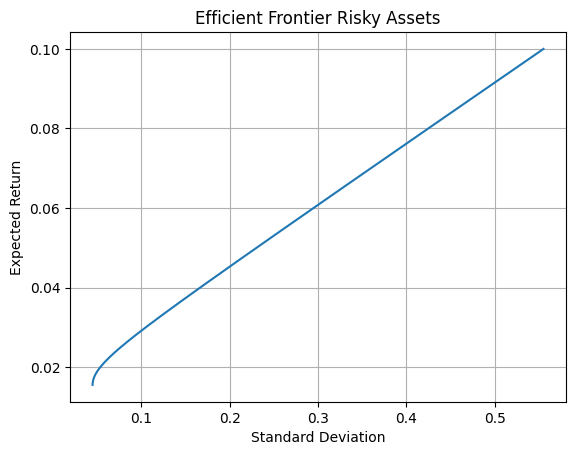

In [304]:
w_MVP = IV1/C
er_min = A/C


m = np.linspace(A/C, 0.1, 150)
Var_w = (C / D) * ((m - A/C)) ** 2 + 1/C
Var_w = Var_w.flatten()
m = m.flatten()

# Graficación de la parte eficiente de la frontera de portafolio
plt.figure()
plt.plot(np.sqrt(Var_w), m)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier Risky Assets')
plt.grid(True)
# plt.xlim(0, 1)
# plt.ylim(-1, 1)
plt.show()


#### FP*: N Risky Asset + RF

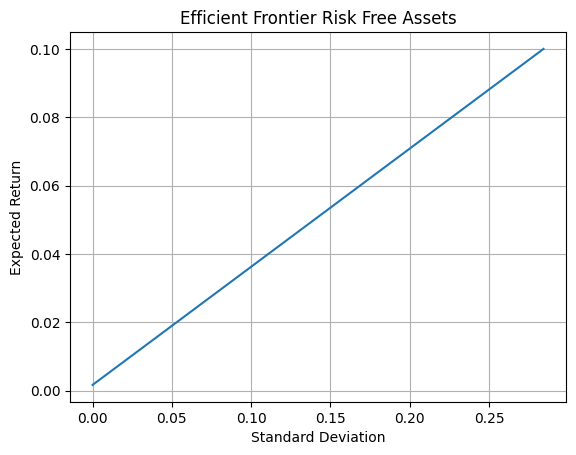

In [305]:
H = B-2 * A * rf_mensile + C * (rf_mensile)**2

mr = np.linspace(rf_mensile, 0.1, 150)
var_rf = ((mr-rf_mensile)**2)/H

var_rf = var_rf.flatten()
mr = mr.flatten()

plt.figure()
plt.plot(np.sqrt(var_rf), mr)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier Risk Free Assets')
plt.grid(True)
plt.show()

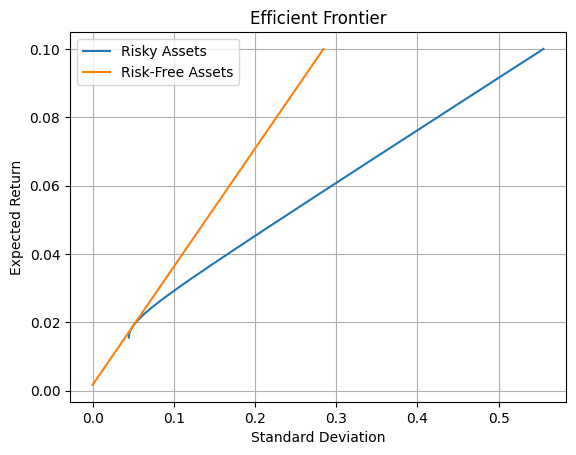

In [306]:
plt.figure()

plt.plot(np.sqrt(Var_w), m, label='Risky Assets')
plt.plot(np.sqrt(var_rf), mr, label='Risk-Free Assets')

plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')

plt.legend()

# plt.xlim(0.029, 0.039)
# plt.ylim(0.011, 0.0145)

plt.grid(True)
plt.show()


In [307]:
import plotly.graph_objs as go
from plotly.offline import iplot


trace1 = go.Scatter(
    x=np.sqrt(Var_w), y=m,
    mode='lines', name='Risky Assets'
)

trace2 = go.Scatter(
    x=np.sqrt(var_rf), y=mr,
    mode='lines', name='Risk-Free Assets'
)


layout = go.Layout(
    title='Efficient Frontier',
    xaxis=dict(title='Standard Deviation'),
    yaxis=dict(title='Expected Return'),
    hovermode='closest'
)


fig = go.Figure(data=[trace1, trace2], layout=layout)

iplot(fig)


4. Compute and plot the efficient portfolio frontier with the same risk-free asset but imposing a no short-selling constraint. Comment on the differences on the portfolio with 0.5% monthly expected return with and without the short-selling constraint.

In [20]:
# Define the optimization function with no short-selling constraint
def minimize_volatility_no_short_selling(target_return, returns, cov_matrix, num_assets):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x * returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1./num_assets,]
    result = minimize(lambda x: np.sqrt(np.dot(x.T, np.dot(cov_matrix, x))), initial_guess,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [21]:
# Compute efficient frontier with no short-selling constraint
target_returns_no_short = np.linspace(expected_returns_array.min(), expected_returns_array.max(), 50)
efficient_portfolios_no_short = [minimize_volatility_no_short_selling(target, expected_returns_array, cov_matrix_array, num_assets) for target in target_returns_no_short]

In [22]:
# Extract volatilities and returns for the efficient frontier with no short-selling
frontier_volatility_no_short = [np.sqrt(np.dot(p['x'].T, np.dot(cov_matrix_array, p['x']))) for p in efficient_portfolios_no_short]
frontier_returns_no_short = [np.sum(p['x'] * expected_returns_array) for p in efficient_portfolios_no_short]

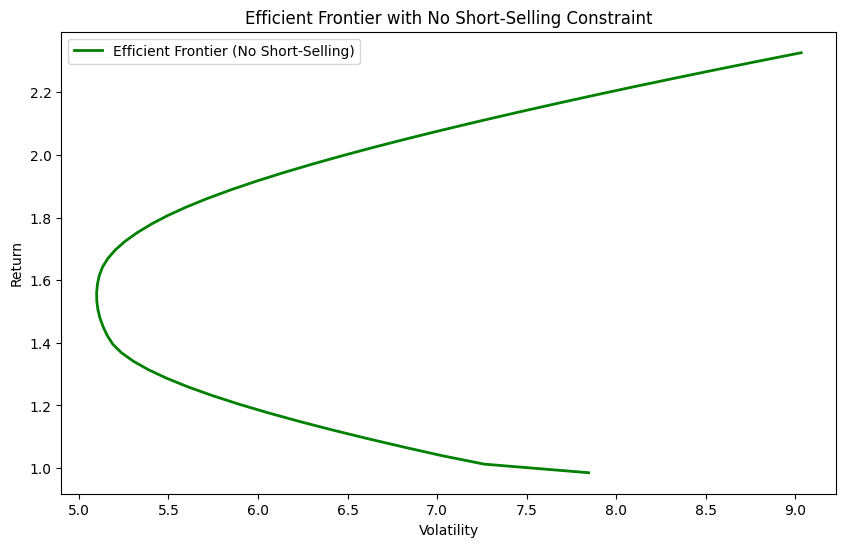

In [23]:
# Plot the efficient frontier with no short-selling constraint
plt.figure(figsize=(10, 6))
plt.plot(frontier_volatility_no_short, frontier_returns_no_short, 'g-', linewidth=2, label='Efficient Frontier (No Short-Selling)')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier with No Short-Selling Constraint')
plt.legend()
plt.show()

In [24]:
# Calculate portfolio weights with short-selling for a 0.5% monthly expected return
target_return_05 = 0.005  # 0.5% monthly return
portfolio_with_short_selling = minimize_volatility(target_return_05)
portfolio_weights_with_short_selling = portfolio_with_short_selling['x']

In [25]:
# Compute the no short-selling portfolio for the same target return
portfolio_no_short_selling = minimize_volatility_no_short_selling(target_return_05, expected_returns_array, cov_matrix_array, num_assets)
portfolio_weights_no_short_selling = portfolio_no_short_selling['x']

# Compare the weights
print("Portfolio Weights with Short-Selling Constraint:", portfolio_weights_with_short_selling)
print("Portfolio Weights without Short-Selling Constraint:", portfolio_weights_no_short_selling)

Portfolio Weights with Short-Selling Constraint: [ 0.12671504  1.          0.23917525 -1.          0.34636738  0.28774233]
Portfolio Weights without Short-Selling Constraint: [8.02971963e-14 1.00000000e+00 4.40897158e-14 0.00000000e+00
 1.07703439e-12 1.43746333e-13]


5.	Estimate CAPM alpha and beta for your stock, use the returns of the S&P 500 as proxy for the market returns. Comment on the results, which of the stocks have generated alpha in the previous years.

###  5. Estimate CAPM alpha and beta for your stocks, use the returns of the S&P 500 (you should obtain returns from S&P 500 prices) as proxy for the market returns. Comment on the results, which of the stocks has generated alpha in the previous years? Assume Rf=0.02.

In [222]:
# Load S&P 500 data
sp500_data_path = './Data/SPX.csv'
sp500_data = pd.read_csv(sp500_data_path)

# Convert 'Date' to datetime and set as index
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)

# Calculate monthly returns for S&P 500
sp500_data['SPX_Returns'] = sp500_data['Price Close'].pct_change()

In [223]:
# Aligning stock returns with S&P 500 returns
aligned_data = unstacked_data['1 Month Total Return'].align(sp500_data['SPX_Returns'], axis=0, join='inner')
stock_returns, market_returns = aligned_data[0], aligned_data[1]

In [224]:
# Perform regression analysis for each stock
for stock in stock_returns.columns:
    # Prepare data for regression
    X = sm.add_constant(market_returns)  # Market returns
    y = stock_returns[stock]  # Stock returns

    # Perform linear regression
    model = sm.OLS(y, X, missing='drop').fit()
    alpha, beta = model.params

    # Output results
    print(f"Stock: {stock}")
    print(f"Alpha (α): {alpha}, Beta (β): {beta}\n")

Stock: BIIB.OQ
Alpha (α): 0.008985761987752118, Beta (β): 0.6056533820665593

Stock: BIO.N
Alpha (α): -0.00028528017093178333, Beta (β): 1.0610530336947939

Stock: LKQ.OQ
Alpha (α): 0.002917216458923055, Beta (β): 1.1431666829306721

Stock: MKTX.OQ
Alpha (α): 0.015990517735754, Beta (β): 0.7614053177428972

Stock: TXT.N
Alpha (α): -0.0031056564387843565, Beta (β): 1.487895384891568

Stock: VRSK.OQ
Alpha (α): 0.009399226665716376, Beta (β): 0.6293362273439004



6. Compute market implicit returns Π in a Black Litterman framework. And compute the market portfolio.

$$
\Pi = \text{diag}(\tau \cdot \Sigma) \cdot \text{W}_{\text{market}}
$$

Where:
- $\Pi$ represents the market implicit returns,
- $\tau$ is a scalar representing the risk aversion coefficient,
- $\Sigma$ is the covariance matrix of the asset returns,
- $\text{W}_{\text{market}}$ denotes the market capitalization weights of the assets.

In [225]:
# Load data including 'Company Market Cap'
dataframes_market_cap = [pd.read_csv(file, usecols=['Instrument', 'Date', 'Company Market Cap']) for file in file_paths]

# Process these dataframes
processed_market_cap_dfs = []
for df in dataframes_market_cap:
    # Convert 'Date' to datetime and set as index with 'Instrument'
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index(['Date', 'Instrument'], inplace=True)
    
    # Keep only the 'Company Market Cap' column
    processed_market_cap_dfs.append(df)

# Merge all market cap dataframes on the multi-index
merged_market_cap_data = pd.concat(processed_market_cap_dfs, axis=0)

In [226]:
# Extracting and averaging market capitalization data
market_caps = merged_market_cap_data.groupby(level='Instrument')['Company Market Cap'].mean()

In [227]:
# Set the risk aversion coefficient (τ)
tau = 0.05  # Adjust as needed

# Calculate market weights
total_market_cap = market_caps.sum()
market_weights = market_caps / total_market_cap

# Assuming 'var_cov_matrix' is your covariance matrix from earlier calculations
# Calculate market implicit returns (Π)
Pi = np.dot(np.diag(tau * var_cov_matrix), market_weights)

In [228]:
# Objective function to minimize (Variance)
def portfolio_variance(weights, covariance_matrix):
    return np.dot(weights.T, np.dot(covariance_matrix, weights))

# Constraints for optimization
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights is 1
bounds = [(0, 1) for _ in range(len(market_weights))]  # No short selling

# Initial guess (equal distribution)
initial_weights = np.full(len(market_weights), 1/len(market_weights))

# Perform the optimization
optimized_result = minimize(portfolio_variance, initial_weights, args=(var_cov_matrix,), 
                            method='SLSQP', bounds=bounds, constraints=constraints)

# Optimized market portfolio weights
optimized_weights = optimized_result.x

In [229]:
# Print Market Capitalization Weights
print("Market Capitalization Weights:")
print(market_weights)

# Print Market Implicit Returns (Π)
print("\nMarket Implicit Returns (Π):")
print(Pi)

# Print Optimized Market Portfolio Weights
print("\nOptimized Market Portfolio Weights:")
print(optimized_weights)

Market Capitalization Weights:
Instrument
BIIB.OQ    0.459742
BIO.N      0.071813
LKQ.OQ     0.081056
MKTX.OQ    0.062200
TXT.N      0.124555
VRSK.OQ    0.200634
Name: Company Market Cap, dtype: float64

Market Implicit Returns (Π):
3.719047853749381

Optimized Market Portfolio Weights:
[0.17410965 0.06005538 0.10731056 0.11647239 0.04810037 0.49395167]


----

7.	Formulate at least two Black Litterman views for the returns of the stocks in your portfolio for January 2023 (for formulating the views you can use historical averages, news and or public balance sheet data). 

**BIIB.OQ (Biogen Inc.) - Views**

**View 1:**
- **Expected Return:** 7%
- **Confidence Level:** High
- **Rationale:** Strong results from new Alzheimer's drug trials.

**View 2:**
- **Expected Return:** 5%
- **Confidence Level:** Moderate
- **Rationale:** Potential regulatory challenges affecting drug approvals.

**BIO.N (Bio-Rad Laboratories) - Views**

**View 1:**
- **Expected Return:** 5%
- **Confidence Level:** Moderate
- **Rationale:** Consistent performance in diagnostics and research sectors.

**View 2:**
- **Expected Return:** 4%
- **Confidence Level:** Low
- **Rationale:** Potential market saturation in key product lines.

**LKQ.OQ (LKQ Corporation) - Views**

**View 1:**
- **Expected Return:** 3%
- **Confidence Level:** Moderate
- **Rationale:** Steady demand in the automotive parts industry.

**View 2:**
- **Expected Return:** 2%
- **Confidence Level:** Low
- **Rationale:** Global supply chain disruptions affecting inventory.

**TXT.N (Textron Inc.) - Views**

**View 1:**
- **Expected Return:** 4%
- **Confidence Level:** Moderate
- **Rationale:** New government contracts for defense equipment.

**View 2:**
- **Expected Return:** 3%
- **Confidence Level:** Low
- **Rationale:** Economic uncertainties affecting industrial sectors.

**VRSK.OQ (Verisk Analytics) - Views**

**View 1:**
- **Expected Return:** 6%
- **Confidence Level:** High
- **Rationale:** Growing demand for risk assessment and data analytics services.

**View 2:**
- **Expected Return:** 4%
- **Confidence Level:** Moderate
- **Rationale:** Competitive pressures in the data analytics market.

**MKTX.OQ (MarketAxess) - Views**

**View 1:**
- **Expected Return:** 2%
- **Confidence Level:** Low
- **Rationale:** Challenges from market volatility in the fintech sector.

**View 2:**
- **Expected Return:** 1%
- **Confidence Level:** Low
- **Rationale:** Regulatory changes potentially impacting operations.

-----

In [34]:
### Portfolio A (Optimistic Scenario)

# Portfolio A Views (Optimistic)
views_A = np.array([0.07, 0.05, 0.04, 0.04, 0.06, 0.03])  
confidence_A = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

# Common parameters for Black Litterman model
tau_A = 0.05
P_A = np.eye(len(views_A))


### Portfolio B (Conservative Scenario)
# Portfolio B Views (Conservative)
views_B = np.array([0.04, 0.02, 0.02, 0.03, 0.04, 0.01])  # Hypothetical expected returns for each stock
confidence_B = np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05])  # Lower confidence in each view

# Common parameters for Black Litterman model
tau_B = 0.05  # Adjust as needed for Portfolio B
P_B = np.eye(len(views_B))  # Identity matrix for Pick matrix


### Function for Black Litterman Adjusted Returns
def black_litterman_adjusted_returns(views, confidence, P, tau, Sigma, Pi):
    # Ensure Pi is a column vector
    Pi = Pi.reshape(-1, 1) if Pi.ndim == 1 else Pi

    # Convert views and confidence to column vectors
    views = np.array(views).reshape(-1, 1)
    confidence = np.array(confidence).reshape(-1, 1)

    # Calculate Omega using the diagonal of confidence
    omega = np.diagflat(confidence)

    # Calculate the Black Litterman adjusted returns
    middle_term = np.linalg.inv(P.T @ np.linalg.inv(omega) @ P + np.linalg.inv(tau * Sigma))
    adjusted_returns = middle_term @ (P.T @ np.linalg.inv(omega) @ views + np.linalg.inv(tau * Sigma) @ Pi)

    # Return adjusted returns as a flat array
    return adjusted_returns.flatten()

### Calculate Adjusted Returns for Both Portfolios


# Calculate adjusted returns for Portfolio A
adjusted_returns_A = black_litterman_adjusted_returns(views_A, confidence_A, P_A, tau_A, var_cov_matrix, Pi)

# Calculate adjusted returns for Portfolio B
adjusted_returns_B = black_litterman_adjusted_returns(views_B, confidence_B, P_B, tau_B, var_cov_matrix, Pi)


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)